<a href="https://colab.research.google.com/github/kamilenovaes/machine-learning-python/blob/main/notebooks/09-random-forests-xgboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Random Forest e XGBoost: Comparando o desempenho



## 🎯 Objetivos

- Treinar um **Random Forest Regressor** (scikit-learn) e um **XGBoost Regressor** (xgboost)
- Comparar **qualidade de predição** (*MSE* e *R²*) e **tempo de execução** (treino e predição)

Vamos prever preços (alvo contínuo) usando o **California Housing Dataset** e comparar dois modelos baseados em árvores:

- **Random Forest**: conjunto (*ensemble*) de várias árvores treinadas de forma relativamente independente (bagging).
- **XGBoost**: *gradient boosting*, onde árvores são adicionadas sequencialmente para corrigir erros das anteriores.

Aqui, "desempenho" significa **duas coisas ao mesmo tempo**:

1. **Acurácia em regressão** (MSE e R² no conjunto de teste)
2. **Velocidade** (tempo de treino e tempo para prever)


## 1. Bibliotecas


In [15]:
# opcional
#!pip install pandas
#!pip install numpy==2.2.0
#!pip install scikit-learn==1.6.0
#!pip install matplotlib==3.9.3
#!pip install xgboost==2.1.3


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error, r2_score
import time


## 2. Carregando e preparando os dados

1. Carregar o dataset a partir de uma URL (CSV)
2. Separar **features** (`X`) do **alvo** (`y`)
3. Dividir em treino e teste

> OBS: o `random_state` garante que a divisão seja reprodutível.


In [17]:
# Carrega o dataset California Housing (CSV)
df = pd.read_csv(
    "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/UZPRFNucrENAFm25csq6eQ/California-housing.csv"
)

# Separa features (X) e alvo (y)
X = df.drop(columns=["Target"])
y = df["Target"]

# Divide em treino e teste (80% / 20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


### Exercício 1 — Quantas observações e features o dataset possui?

- **Observações** = número de linhas (amostras)
- **Features** = número de colunas de entrada


In [18]:
n_observacoes, n_features = X.shape
print(f"Número de observações: {n_observacoes}")
print(f"Número de features: {n_features}")


Número de observações: 20640
Número de features: 8


Esse dataset tem tamanho moderado. Estamos comparando os modelos **apenas neste conjunto de dados**, em escalas diferentes (mais dados, mais features, outra distribuição) o “vencedor” pode mudar.


## 3. Inicializando os modelos

Para comparar de forma justa, vamos usar o **mesmo número de árvores** (`n_estimators`) nos dois modelos e manter os demais hiperparâmetros como padrão.

- `n_estimators`: quantas árvores o ensemble terá (mais árvores tende a melhorar desempenho, mas aumenta tempo).


In [19]:
n_estimators = 100

rf = RandomForestRegressor(
    n_estimators=n_estimators,
    random_state=42
)

xgb = XGBRegressor(
    n_estimators=n_estimators,
    random_state=42
)


## 4. Treinamento (com medição de tempo)

A ideia é medir quanto tempo cada modelo leva para **ajustar** (aprender) no conjunto de treino.


In [20]:
# Tempo de treino — Random Forest
t0 = time.time()
rf.fit(X_train, y_train)
rf_train_time = time.time() - t0

# Tempo de treino — XGBoost
t0 = time.time()
xgb.fit(X_train, y_train)
xgb_train_time = time.time() - t0


### Exercício 2 — Predição

Agora vamos:

1. Fazer previsões no conjunto de teste
2. Medir o tempo de predição (inferência) de cada modelo


In [21]:
# Tempo de predição — Random Forest
t0 = time.time()
y_pred_rf = rf.predict(X_test)
rf_pred_time = time.time() - t0

# Tempo de predição — XGBoost
t0 = time.time()
y_pred_xgb = xgb.predict(X_test)
xgb_pred_time = time.time() - t0


### Exercício 3 — Calcular métricas (MSE e R²)

- **MSE (Mean Squared Error)**: erro quadrático médio. *Quanto menor, melhor.*
- **R²**: fração da variância do alvo explicada pelo modelo. *Quanto mais perto de 1, melhor.*  
  (Pode ser negativo se o modelo for pior que um baseline simples.)


In [22]:
mse_rf = mean_squared_error(y_test, y_pred_rf)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)

r2_rf = r2_score(y_test, y_pred_rf)
r2_xgb = r2_score(y_test, y_pred_xgb)


### Exercício 4 — Exibir as métricas


In [23]:
print(f"Random Forest  | MSE = {mse_rf:.4f} | R² = {r2_rf:.4f}")
print(f"XGBoost        | MSE = {mse_xgb:.4f} | R² = {r2_xgb:.4f}")


Random Forest  | MSE = 0.2554 | R² = 0.8051
XGBoost        | MSE = 0.2226 | R² = 0.8301


XGBoost tem **menor MSE** e **maior R²**, ele está performando melhor em termos de qualidade de predição. Mas ainda precisamos olhar o **custo computacional**.


### Exercício 5 — Exibir os tempos (treino e predição)


In [24]:
print(f"Random Forest  | Treino = {rf_train_time:.3f}s | Predição = {rf_pred_time:.3f}s")
print(f"XGBoost        | Treino = {xgb_train_time:.3f}s | Predição = {xgb_pred_time:.3f}s")


Random Forest  | Treino = 21.784s | Predição = 0.159s
XGBoost        | Treino = 0.395s | Predição = 0.012s


Tempo importa porque:

- Em **produção**, você pode precisar prever em tempo real.
- Em **experimentos**, você pode treinar muitos modelos (grid search, validação, etc.), então modelos mais rápidos reduzem custo e tempo.


### Exercício 6 — Desvio padrão do alvo no teste

Vamos usar o desvio padrão de `y_test` para criar uma “faixa” de referência: ±1 desvio padrão ao redor da linha perfeita (*y = ŷ*).


In [25]:
std_y = np.std(y_test)
std_y


1.144730963257702

## 5. Visualização: valores reais vs. previstos

Gráficos de dispersão:

- Eixo x: valor **real**
- Eixo y: valor **previsto**

A linha preta tracejada é o **modelo perfeito** (*y = ŷ*).  
As linhas vermelhas tracejadas representam ±1 desvio padrão do alvo, apenas como referência visual.


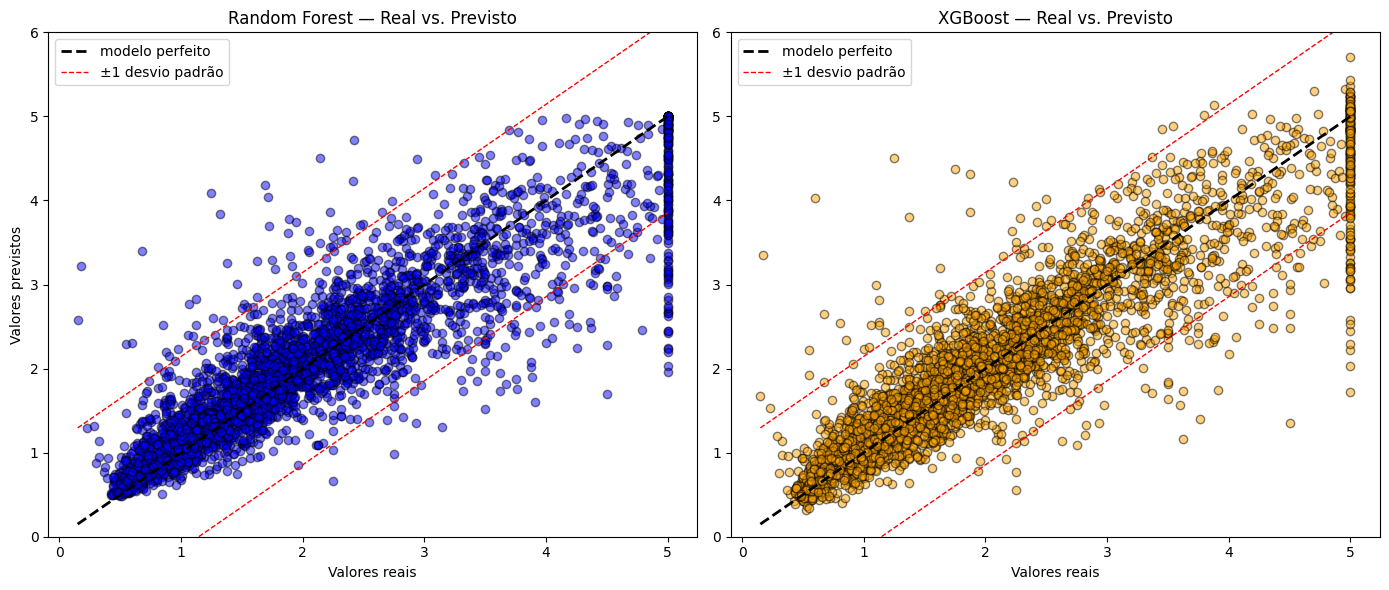

In [26]:
plt.figure(figsize=(14, 6))

# Random Forest
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_rf, alpha=0.5, color="blue", ec="k")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--", lw=2, label="modelo perfeito")
plt.plot([y_test.min(), y_test.max()],
         [y_test.min() + std_y, y_test.max() + std_y],
         "r--", lw=1, label="±1 desvio padrão")
plt.plot([y_test.min(), y_test.max()],
         [y_test.min() - std_y, y_test.max() - std_y],
         "r--", lw=1)
plt.ylim(0, 6)
plt.title("Random Forest — Real vs. Previsto")
plt.xlabel("Valores reais")
plt.ylabel("Valores previstos")
plt.legend()

# XGBoost
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_xgb, alpha=0.5, color="orange", ec="k")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--", lw=2, label="modelo perfeito")
plt.plot([y_test.min(), y_test.max()],
         [y_test.min() + std_y, y_test.max() + std_y],
         "r--", lw=1, label="±1 desvio padrão")
plt.plot([y_test.min(), y_test.max()],
         [y_test.min() - std_y, y_test.max() - std_y],
         "r--", lw=1)
plt.ylim(0, 6)
plt.title("XGBoost — Real vs. Previsto")
plt.xlabel("Valores reais")
plt.legend()

plt.tight_layout()
plt.show()


## Conclusão

- Use as **métricas** (MSE e R²) para comparar a qualidade de predição.
- Use os **tempos** (treino e predição) para comparar custo computacional.
- Os gráficos ajudam a entender *onde* o modelo erra e se há padrões de erro (ex.: “estoura” valores altos).

> Outros passos (plus): testar hiperparâmetros (ex.: `max_depth`, `learning_rate`, `subsample` no XGBoost) e usar validação cruzada para uma comparação mais robusta.
